# The simple model 12
Доработанная сеть 2.0 от Megnet

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

!pip install matminer
!pip install pymatgen
!pip install maml
!git clone https://github.com/bvd757/3DSC.git
!pip install megnet

from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph

from pymatgen.core.structure import Structure
from maml.describers import BPSymmetryFunctions

!pip install monty
from monty.json import MontyDecoder
from monty.serialization import loadfn

from megnet.data.crystal import CrystalGraph
from megnet.data.graph import GaussianDistance
from megnet.models import MEGNetModel

In [14]:
data = pd.read_csv('https://raw.githubusercontent.com/aimat-lab/3DSC/main/superconductors_3D/data/final/MP/3DSC_MP.csv', header = 1)
data1 = data.loc[data['tc'] > 0.1]
#data1 = data1.loc[data['tc'] < 30.0]
data_t = np.log(data1[['tc']])
data2 = data1[['formula_sc']]

In [15]:
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.conversions import StrToComposition
ep_feat = ElementProperty.from_preset(preset_name="magpie")
d = {"element": np.array(data2)[:, 0]}
df = pd.DataFrame(d)

df = StrToComposition().featurize_dataframe(df, "element")
df = ep_feat.featurize_dataframe(df, col_id = 'composition')

StrToComposition:   0%|          | 0/3950 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/3950 [00:00<?, ?it/s]

In [ ]:
structures1 = [0] * len(df)
targets1 = [0] * len(df)
type_s = [0] * len(df)
l = len(df)
for i in enumerate(os.listdir(path="/content/3DSC/superconductors_3D/data/final/MP/cifs")):
    if i[0] % 100 == 0: print(i[0])
    #print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n", i[1], "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")
    if i[1][:i[1].find('-MP')] not in df['element'].to_list(): continue
    j = df.loc[df['element'] == i[1][:i[1].find('-MP')]].index
    k = data1.loc[data1['formula_sc'] == i[1][:i[1].find('-MP')]].index
    j = j[0]
    k = k[0]
    cif = Structure.from_file("/content/3DSC/superconductors_3D/data/final/MP/cifs/" + i[1])
    structures1[j] = cif
    type_s[j] = data1['sc_class'].loc[k]
    targets1[j] = data_t.loc[k]['tc']

df1 = df[['MagpieData mean AtomicWeight', 'MagpieData mean MeltingT',
'MagpieData mean Electronegativity', 'MagpieData mean NdValence', 'MagpieData mean GSvolume_pa', 'MagpieData mean SpaceGroupNumber', 'MagpieData mean NdUnfilled']]

In [17]:
df1 = df[['element']]
df1['tc'] = np.array(targets1)
df1['sc_class'] = type_s
df1

<ipython-input-17-04c063078003>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['tc'] = np.array(targets1)
<ipython-input-17-04c063078003>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['sc_class'] = type_s


,element,tc,sc_class
0,Ag0.02Ge2Pd1.98Sr1,0.970779,Other
1,Ag0.15Sn0.85Te1,0.765468,Other
2,Ag0.1Ge2Pd1.9Sr1,0.963174,Other
3,Ag0.1In0.9Te1,0.182322,Other
4,Ag0.2Ba1Si1.8,1.163151,Other
...,...,...,...
3945,W2Zr1,0.076961,Other
3946,W3O1,0.515813,Oxide
3947,Zn1,-0.161578,Other
3948,Zn2Zr1,-1.215146,Other


In [18]:
from megnet.utils.models import load_model, AVAILABLE_MODELS
from pymatgen.core import Structure, Lattice
from pymatgen.ext.matproj import MPRester
print(AVAILABLE_MODELS)

['Eform_MP_2019', 'Eform_MP_2018', 'Efermi_MP_2019', 'Bandgap_classifier_MP_2018', 'Bandgap_MP_2018', 'logK_MP_2018', 'logG_MP_2018', 'logK_MP_2019', 'logG_MP_2019']


In [ ]:
model = load_model('Efermi_MP_2019')
model.compile(loss='mse')

In [20]:
structure_for_test = Structure.from_file("/content/3DSC/superconductors_3D/data/final/MP/cifs/" + 'Ag0.55Hg0.45-MP-mp-770433.cif')
A = []
B = []
for i in range(len(structures1)):
    if i % 100 == 0:
        print(i, len(B) / (i + 1))
        
    if structures1[i] == 0:
        B.append(i)
        continue

    try:
        model.train([structure_for_test, structures1[i]], [1, 1], epochs=1,  verbose = 0);
        A.append(i)
    except:
        B.append(i)

B = sorted(B, reverse = True)

In [21]:
structures2 = structures1.copy()
targets2 = targets1.copy()
df2 = df1.copy()
df2.index = np.arange(len(df2))
df2.drop(labels=B, axis=0, inplace=True)

for i in B:
    structures2.pop(i)
    targets2.pop(i)

In [24]:
df3 = df2.copy()
df3.index = np.arange(len(df3))
D = df3[df3['sc_class'] != 'Other'].index
df_Other = df3[df3['sc_class'] == 'Other']
D = sorted(D, reverse = True)
for i in D:
    structures2.pop(i)
    targets2.pop(i)

In [ ]:
X_train, y_train = structures2[:50], targets2[:50]
losses = [0] * len(AVAILABLE_MODELS)
for i, model_name in enumerate(AVAILABLE_MODELS):
    model = load_model(model_name)
    model.compile(loss='mse')
    history = model.train(X_train, y_train, epochs = 5, batch_size = 10, verbose = 0, save_checkpoint = True)
    losses[i] = history.history.history['loss'][-1]
    print(model_name, history.history.history['loss'])
    print()

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Eform_MP_2019 [2.1474087238311768, 0.9767575263977051, 0.5070415735244751, 0.34987443685531616, 0.17392779886722565]

Eform_MP_2018 [1.8736951351165771, 0.9781746864318848, 0.5319128036499023, 0.30567044019699097, 0.16810809075832367]

Efermi_MP_2019 [2.1950862407684326, 0.5225740075111389, 0.2375660240650177, 0.14253461360931396, 0.11114346981048584]

Bandgap_classifier_MP_2018 [1.5310440063476562, 1.1769440174102783, 1.027512550354004, 1.0540869235992432, 0.9073073267936707]

Bandgap_MP_2018 [2.0343403816223145, 1.0453341007232666, 0.6563485860824585, 0.4554230272769928, 0.3879273533821106]

logK_MP_2018 [2.614320993423462, 2.0634939670562744, 1.8494062423706055, 1.7305173873901367, 1.5817363262176514]

logG_MP_2018 [2.228929042816162, 1.6805260181427002, 1.3666150569915771, 1.2271977663040161, 1.0542421340942383]

logK_MP_2019 [6.744297981262207, 5.976956844329834, 5.531365394592285, 5.243750095367432, 5.037966728210449]

logG_MP_2019 [7.599518775939941, 6.987666130065918, 6.6836295

In [ ]:
X_train, y_train = structures2[:800], targets2[:800] 
X_validation, y_validation = structures2[800:1000], targets2[800:1000]
history = model.train(train_structures=X_train, train_targets=y_train, validation_structures=X_validation, 
                      validation_targets=y_validation, epochs = 100, batch_size = 10, verbose = 1)
history.history.history['loss']

In [ ]:
epochs = 1000
train_loss = [0] * epochs
validation_loss = [0] * epochs
X_train, y_train = structures2[:1000], targets2[:1000]
X_validation, y_validation = structures2[1000:], targets2[1000:]
model = load_model('Bandgap_MP_2018')
model.compile(loss='mse')
t = model.copy()
history = model.train(train_structures=X_train[:10], train_targets=y_train[:10], epochs = 1, batch_size = 1, verbose = 0)
b = model.get_weights()

In [ ]:
for epoch in range(epochs):
    print("epoch =", epoch + 1)
    print('train')
    if epoch != 0: model.set_weights(weights)
    history = model.train(train_structures=X_train, train_targets=y_train, epochs = 1, batch_size = 100, verbose = 1)
    train_loss[epoch] = history.history.history['loss'][-1]

    print()
    print('validation')
    weights = model.get_weights()
    weights_massive.append(weights)
    history = model.train(train_structures=X_validation, train_targets=y_validation, epochs = 1, batch_size = 100, verbose = 1)
    validation_loss[epoch] = history.history.history['loss'][-1]
    print("\n\n")

In [ ]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.history = {'loss':[],'val_loss':[]}

    def on_batch_end(self, batch, logs={}):
        self.history['loss'].append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.history['val_loss'].append(logs.get('val_loss'))

history = LossHistory()

X_train, y_train = structures2[:10], targets2[:10]
X_validation, y_validation = structures2[10:12], targets2[10:12]
model = load_model('Bandgap_MP_2018')
model.compile(loss='mse', metrics=['val_loss'])
model.train(train_structures = X_train, train_targets = y_train, 
                      validation_structures = X_validation, validation_targets = y_validation, epochs = 1, batch_size = 1, verbose = 1, validation_freq=1, callbacks=[history])

In [ ]:
history.val_losses

[None, None, None, None, None, None, None, None, None, None]

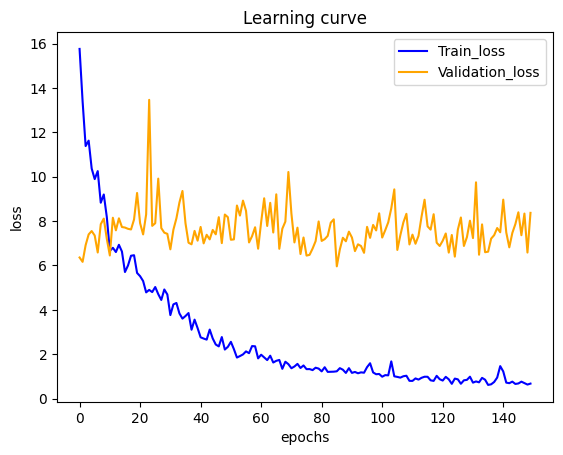

In [ ]:
fig, ax = plt.subplots()
ax.grid()
plt.grid()
plt.plot(np.arange(epochs), train_loss, color = 'blue', label = "Train_loss")
plt.plot(np.arange(epochs), validation_loss, color = 'orange', label = "Validation_loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Learning curve")
#plt.ylim((0, 4))
plt.legend()
plt.show()

In [ ]:
X_train, y_train = structures2[:850], targets2[:850]
X_test, y_test = structures2[850:], targets2[850:]
model = load_model('Efermi_MP_2019')
model.compile(loss='mse')
history = model.train(train_structures=X_train, train_targets=y_train, epochs = 300, batch_size = 10, verbose = 1)
loss = history.history.history['loss']

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/300
85/85 [==============================] - 35s 143ms/step - loss: 0.3007
Epoch 2/300
85/85 [==============================] - 12s 143ms/step - loss: 0.1206
Epoch 3/300
85/85 [==============================] - 11s 134ms/step - loss: 0.1003
Epoch 4/300
85/85 [==============================] - 12s 139ms/step - loss: 0.0994
Epoch 5/300
85/85 [==============================] - 11s 129ms/step - loss: 0.0804
Epoch 6/300
85/85 [==============================] - 12s 144ms/step - loss: 0.0777
Epoch 7/300
85/85 [==============================] - 12s 141ms/step - loss: 0.0658
Epoch 8/300
85/85 [==============================] - 12s 138ms/step - loss: 0.0652
Epoch 9/300
85/85 [==============================] - 12s 138ms/step - loss: 0.0607
Epoch 10/300
85/85 [==============================] - 12s 138ms/step - loss: 0.0545
Epoch 11/300
85/85 [==============================] - 10s 119ms/step - loss: 0.0491
Epoch 12/300
85/85 [==============================] - 12s 138ms/step - loss: 0.0533
E

In [ ]:
loss

In [ ]:
predictions_g1 = np.zeros(len(X_train))
for i in range(len(X_train)):
    print(i)
    predictions_g1[i] = model.predict_structure(X_train[i]).ravel()

In [ ]:
predictions_g = np.zeros(len(X_test))
for i in range(len(X_test)):
    print(i)
    predictions_g[i] = model.predict_structure(X_test[i]).ravel()

In [ ]:
train_loss = ((predictions_g1 - y_train) ** 2).sum()
test_loss = ((predictions_g - y_test) ** 2).sum()
print(train_loss)
print(test_loss)

154.81541004248103
108.91135589825174


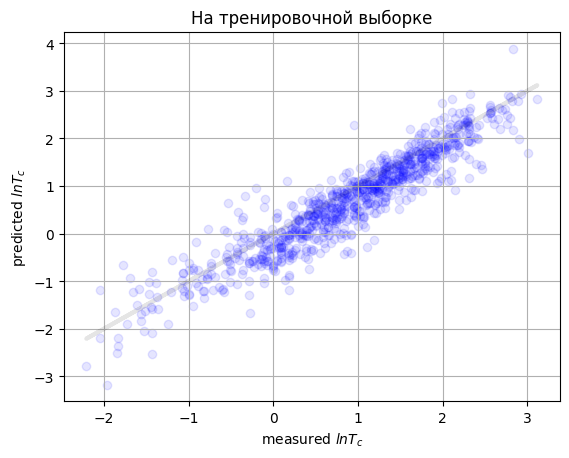

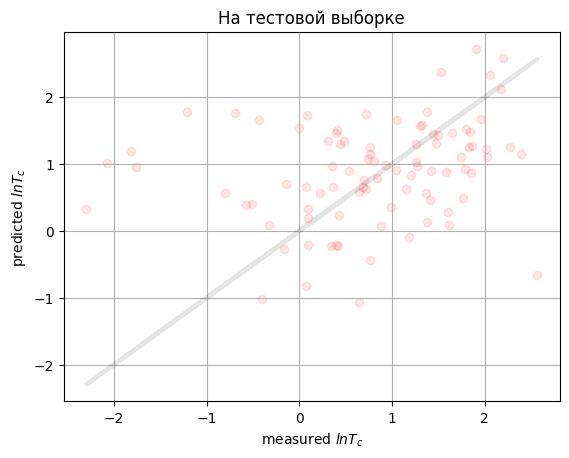

In [ ]:
fig, ax = plt.subplots()
ax.grid()


plt.scatter(y_train, predictions_g1, color = 'blue', alpha = 0.1)
plt.plot(y_train, y_train, color = 'black', linewidth = 3, alpha = 0.1)
ax.set_xlabel('measured $ln T_c$')
ax.set_ylabel('predicted $ln T_c$')
plt.title("На тренировочной выборке")
#plt.ylim((0, 4))
plt.show()

plt.grid()
plt.scatter(y_test, predictions_g, color = 'red', alpha = 0.1)
plt.plot(y_test, y_test, color = 'black', linewidth = 3, alpha = 0.1)
plt.xlabel('measured $ln T_c$')
plt.ylabel('predicted $ln T_c$')
plt.title("На тестовой выборке")
#plt.ylim((0, 4))
plt.show()

In [ ]:
X_train, y_train = df2[:1000], targets2[:1000]
X_test, y_test = df2[1000:], targets2[1000:]

param_grid = { 
            "n_estimators"      : [30, 100, 300],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            }
rfr = RandomForestRegressor()
CV_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 5)
CV_rfr.fit(X_train, y_train)

In [ ]:
CV_rfr.best_params_

{'bootstrap': True,
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'n_estimators': 300}

In [ ]:
rfr1 = RandomForestRegressor(max_features = 'sqrt', min_samples_split = 4, bootstrap = True, n_estimators = 100)
rfr1.fit(X_train, y_train)
predictions = rfr1.predict(X_test)
predictions1 = rfr1.predict(X_train)

In [ ]:
train_loss = ((predictions1 - y_train) ** 2).sum()
test_loss = ((predictions - y_test) ** 2).sum()
print(train_loss)
print(test_loss)

1545683.924147896
24526.622424673278


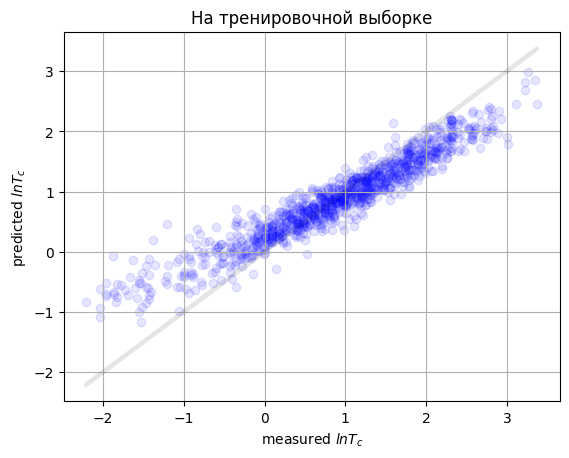

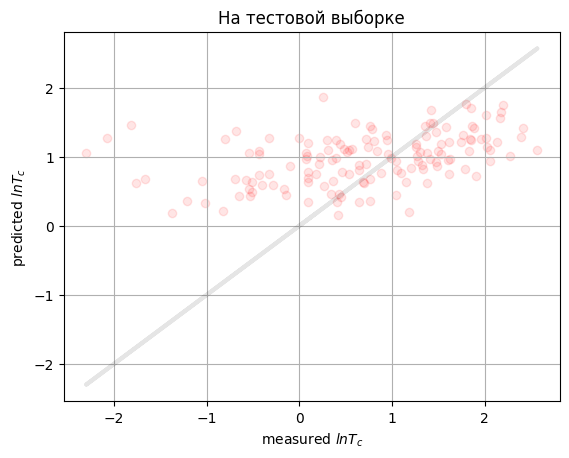

In [ ]:
fig, ax = plt.subplots()
ax.grid()


plt.scatter(y_train, predictions1, color = 'blue', alpha = 0.1)
plt.plot(y_train, y_train, color = 'black', linewidth = 3, alpha = 0.1)
ax.set_xlabel('measured $ln T_c$')
ax.set_ylabel('predicted $ln T_c$')
plt.title("На тренировочной выборке")
#plt.ylim((0, 4))
plt.show()

plt.grid()
plt.scatter(y_test, predictions, color = 'red', alpha = 0.1)
plt.plot(y_test, y_test, color = 'black', linewidth = 3, alpha = 0.1)
plt.xlabel('measured $ln T_c$')
plt.ylabel('predicted $ln T_c$')
plt.title("На тестовой выборке")
#plt.ylim((0, 4))
plt.show()